<a href="https://colab.research.google.com/github/rishabh422tiwari/Backproagation_Introduction/blob/main/backprop_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Backpropagation Introduction

Backpropagation is the algorithm which allows you to efficiently evaluate the gradient of some kind of loss function with respect to weights
of a neural network and what it allows us to do is iteratively tune the weights of that NN to minimize the loss function therefore increasing the accuraacy of the network. 

In [124]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [125]:
def f(x):
    return 3*x**2 - 4*x + 5

In [126]:
f(4.0)

37.0

In [127]:
xs = np.arange(-5,5, 0.25)
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

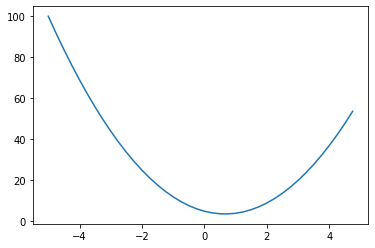

In [128]:
plt.plot(xs, ys)

In [129]:
h = 0.001
x = 3.0
f(x + h)

20.014003000000002

In [130]:
#h = 0.001                            # little below 20 that means around -21 or -22
#x = -3.0
#f(x + h)

In [131]:
f(x + h) - f(x)                       # difference between the value of the expression before nudging and after nudging the value of x

0.01400300000000243

In [132]:
(f(x + h) - f(x))/h                   # this is normalizer form and this value is giving the slope of the expression
                                      # if i nudge the value of x how it will affect the expression thats what slope is

14.00300000000243

In [133]:
# lets get more complex
a = 2.0
b =-3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [134]:
h = 0.0001

#inputs
a = 2.0
b =-3.0
c = 10.0

d1 = a*b + c
a += h                          # bumping the value of 'a' with little
d2 = a*b + c                    

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)



d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [135]:
d1 = a*b + c
b += h                          # bumping the value of 'b' with little
d2 = a*b + c                    

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)



d1 3.999699999999999
d2 3.99990001
slope 2.0001000000124947


In [136]:
d1 = a*b + c
c += h                          # bumping the value of 'c' with little
d2 = a*b + c                    

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)



d1 3.99990001
d2 4.00000001
slope 0.9999999999976694


In [137]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')                             # this is the forward pass of the network i.e we have not performed the backpropagation
e = a*b; e.label = 'e'                                 # but calculated the graph (root node, and all the child node)
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L
#(a.__mul__(b)).__add__(c)                      # what python is calling internally

Value(data=-8.0)

In [138]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [139]:
d._op

'+'

In [140]:

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

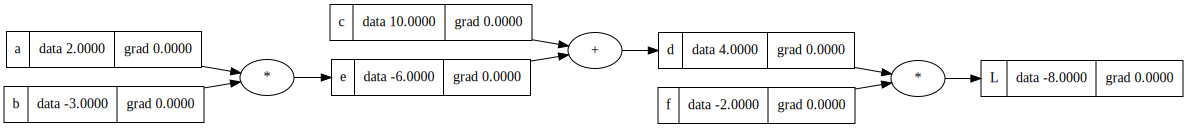

In [141]:
draw_dot(L)

### Grad for **d**
L = d * f

dL/dd = ?  f

( f (x+h) - f(x) ) /h

( (d+h)*f - d*f ) /h

(h*f)/h
f

In [165]:
L.grad = 1.0                # filling grad manually for dL/dL

In [166]:
f.grad = 4.0
d.grad = -2.0

we want to know how e or c effecting L but we cannot compute it directly but we can compute dd/dc then dL/dd (we already have this) and somehow put the both information together get the dL/dc or dL/de.

dd / dc or dd / de is just local derivatives we want to calculate global derivative i.e dL / dc pr dL / de.

d = c + e

(f(x+h) - f(x)) / h

(( c+h + e) - (c+e))/h

(c + h + e - c -e)/h

h/h

1.0


dd / dc = 1.0

dd / de = 1.0

d = c + e

Now how to put both information together we talked about : CHAIN RULE

what is chain rule ?

If a variable z depends on the variable y, which itself depends on the variable x (that is, y and z are dependent variables), then z depends on x as well.

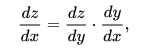

**WANT:**

dL / dc = (dL / dd) * (dd / dc)

**KNOW:**

dL / dd

dd / dc




In [167]:
c.grad = -2.0 
e.grad = -2.0

dL / de = -2.0

e = a * b

de / da ?  b

de / db ?  a

dL / da = (dL / de) * (de / da)

dL / db = (dL / de) * (de / db)

**(remember de / da and de / db are local derivative)**







In [168]:
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

In [169]:
def lol():
  
  h = 0.001
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  
  a = Value(2.0, label='a')
  #a.data += h
  b = Value(-3.0, label='b')
  #b.data += h
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  #e.data += h
  d = e + c; d.label = 'd'
  #d.data += h
  f = Value(-2.0 , label='f')
  #f = Value(-2.0 + h , label='f')
  L = d * f; L.label = 'L'
  L2 = L.data
  
  print((L2 - L1)/h)
  
lol()

0.0


**Let's the Power of what we have built in action**

Now we gonna nudge our inputs try to make L go up.

If we want to up L that means we need to in the direction of gradients.

In [170]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-46.97032704860435


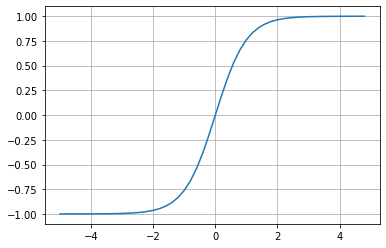

In [171]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [172]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

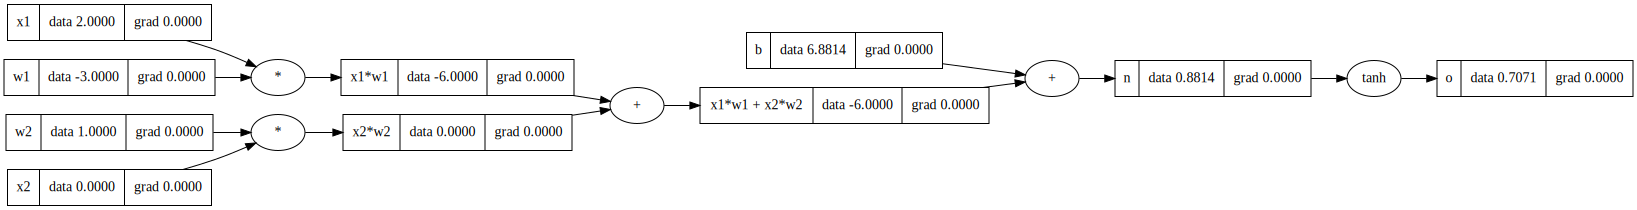

In [173]:
draw_dot(o)

In [174]:
o.grad = 1.0

In [175]:
topo = []                            # topological sort
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [176]:
o._backward()

In [177]:
n._backward()

In [178]:
b._backward()                # we cannot call coz b does not have a _backward it is a leaf node ( initialize to an empty function)

In [179]:
x1w1x2w2._backward()

In [180]:
x1w1._backward()
x2w2._backward()

In [181]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [182]:
w2.grad = x2.data * x2w2.grad                        # interesting thing here is deravative of w2 is 0 and that is fair logically coz
x2.grad = w2.data * x2w2.grad                        # deravative always tell us the effect it has on root node but if x2 is 0 ( x2 * w2)
                                                     # w2 will never have effect on root node that is why it it coming out 0.

In [183]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [184]:
x1w1x2w2.grad = 0.5      # '+' is just a distributor of gradient so this gradient will simply flow to both child node 
b.grad = 0.5             # equally and thats because the local derivative of the operation is 1 for every one of its node.           

In [185]:
n.grad = 0.5

we have seen what tanh looks like, here is the math. formula:

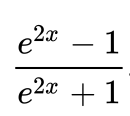

o = tanh(n)

and deravative of tanh is :

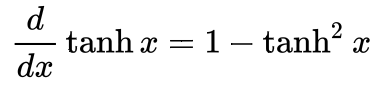

do/dn = 1 - o**2

In [186]:
1 - o.data**2

0.4999999999999999

In [187]:
o.grad = 1.0

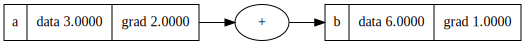

In [190]:
a = Value(3.0, label='a')                # accumulate the gradient when getting gradient from the same variable
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

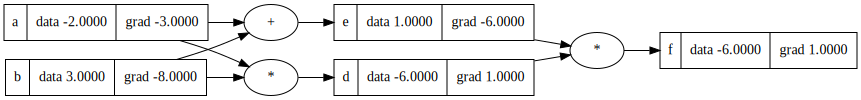

In [191]:
a = Value(-2.0, label='a')               # remember we have to accumilate the gradients i.e our gradient is till d and e after that say we are
b = Value(3.0, label='b')                # checking gradients from '+' operator, gradient will flow equally now what is problem's when gradient  
d = a * b    ; d.label = 'd'             # of '*' will execute it will orverride the gradient of what we got from '+'. so keep in mind to accumulate 
e = a + b    ; e.label = 'e'             # the gradients always. ( our example is after fixing the same variable gradient problem  )
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)